<a href="https://colab.research.google.com/github/OTN-Rajapaksha/Naval-Hybrid-Model-Work-In-The-Stock-Market-And-Crypto-Market-Prediction/blob/main/Using_JKH_Dataset_Find_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load JKH dataset
df_jkh = pd.read_csv('/content/JKH-N0000.CM_2018_2025.csv')
print(f"JKH Dataset Shape: {df_jkh.shape}")
print(f"Columns: {list(df_jkh.columns)}")
print(f"\nFirst 3 rows:")
print(df_jkh.head(3))
print(f"\nMissing values: {df_jkh.isnull().sum().sum()}")


JKH Dataset Shape: (1812, 6)
Columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']

First 3 rows:
                 Price         Close          High           Low  \
0               Ticker  JKH-N0000.CM  JKH-N0000.CM  JKH-N0000.CM   
1                 Date           NaN           NaN           NaN   
2  2018-01-01 00:00:00   147.2368469   147.2368469   147.2368469   

           Open        Volume  
0  JKH-N0000.CM  JKH-N0000.CM  
1           NaN           NaN  
2   147.2368469             0  

Missing values: 5


🔧 STEP 2: PREPROCESSING JKH DATA
Starting JKH data preprocessing...
Original data structure:
                 Price         Close          High           Low  \
0               Ticker  JKH-N0000.CM  JKH-N0000.CM  JKH-N0000.CM   
1                 Date           NaN           NaN           NaN   
2  2018-01-01 00:00:00   147.2368469   147.2368469   147.2368469   
3  2018-01-02 00:00:00   148.7240753   148.9223711   148.7240753   
4  2018-01-03 00:00:00   154.1773071   155.1688011   154.6730541   

           Open        Volume  
0  JKH-N0000.CM  JKH-N0000.CM  
1           NaN           NaN  
2   147.2368469             0  
3   147.4351303         37463  
4   148.7240905        399066  
Original columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Ticker row: ['Ticker', 'JKH-N0000.CM', 'JKH-N0000.CM', 'JKH-N0000.CM', 'JKH-N0000.CM', 'JKH-N0000.CM']
Header row: ['Date', nan, nan, nan, nan, nan]
After cleaning headers:
                  Date        Close         High          Low  

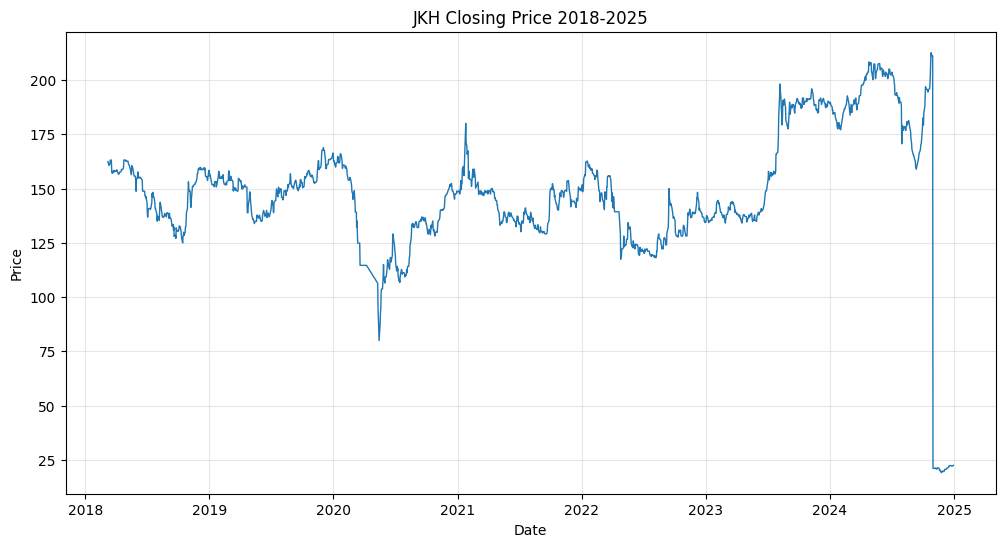


📋 Processed data sample:
                 Close        High         Low        Open  Volume   returns  \
Date                                                                           
2018-03-09  162.406708  163.199906  161.613510  161.613510  421606  0.004908   
2018-03-12  160.721176  160.622021  160.126274  161.811810   32483 -0.010378   
2018-03-13  160.622025  161.613518  159.630531  160.622025  455785 -0.000617   

             price_5ma  price_20ma  price_50ma  volatility_5  volatility_20  \
Date                                                                          
2018-03-09  161.494528  158.391151  158.954320      0.010584       0.008987   
2018-03-12  161.117761  158.728259  159.224007      0.011152       0.007936   
2018-03-13  160.959125  159.060410  159.461966      0.010792       0.007946   

            momentum_5  momentum_10  high_low_range  open_close_range  \
Date                                                                    
2018-03-09    0.793213     3.76

In [4]:
print("🔧 STEP 2: PREPROCESSING JKH DATA")
print("="*50)

def preprocess_jkh_data(df):
    """Preprocess JKH data with proper header handling for the actual structure"""

    # Create a clean copy of the dataframe
    df_clean = df.copy()

    print("Original data structure:")
    print(df_clean.head(5))
    print(f"Original columns: {list(df_clean.columns)}")

    # The actual structure shows:
    # Row 0: Ticker labels
    # Row 1: Column names (but with NaN for some)
    # Row 2+: Actual data

    # Extract proper column names from the first two rows
    ticker_row = df_clean.iloc[0]  # First row with tickers
    header_row = df_clean.iloc[1]  # Second row should have column names

    print(f"Ticker row: {list(ticker_row)}")
    print(f"Header row: {list(header_row)}")

    # Create proper column names by combining information from both rows
    # Based on your output, the columns are: Price, Close, High, Low, Open, Volume
    proper_columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

    # Skip the first two rows (header rows) and use proper column names
    df_clean = df_clean.iloc[2:].reset_index(drop=True)
    df_clean.columns = proper_columns

    print("After cleaning headers:")
    print(df_clean.head(3))

    # Convert data types
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])

    # Convert numeric columns - handle any non-numeric values
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in numeric_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Set Date as index
    df_clean.set_index('Date', inplace=True)

    # Handle missing values
    print(f"\nMissing values before cleaning:")
    print(df_clean.isnull().sum())

    df_clean = df_clean.ffill().bfill()
    print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

    # Calculate technical indicators
    print("Calculating technical indicators...")

    # Price-based features
    df_clean['returns'] = df_clean['Close'].pct_change()
    df_clean['price_5ma'] = df_clean['Close'].rolling(5).mean()
    df_clean['price_20ma'] = df_clean['Close'].rolling(20).mean()
    df_clean['price_50ma'] = df_clean['Close'].rolling(50).mean()

    # Volatility features
    df_clean['volatility_5'] = df_clean['returns'].rolling(5).std()
    df_clean['volatility_20'] = df_clean['returns'].rolling(20).std()

    # Momentum indicators
    df_clean['momentum_5'] = df_clean['Close'] - df_clean['Close'].shift(5)
    df_clean['momentum_10'] = df_clean['Close'] - df_clean['Close'].shift(10)

    # Price ranges
    df_clean['high_low_range'] = (df_clean['High'] - df_clean['Low']) / df_clean['Close']
    df_clean['open_close_range'] = (df_clean['Close'] - df_clean['Open']) / df_clean['Open']

    # RSI calculation
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df_clean['rsi_14'] = calculate_rsi(df_clean['Close'])

    # Volume features
    df_clean['volume_ma_5'] = df_clean['Volume'].rolling(5).mean()
    df_clean['volume_ma_20'] = df_clean['Volume'].rolling(20).mean()
    df_clean['volume_change'] = df_clean['Volume'].pct_change()

    # Target: Next day closing price
    df_clean['target_price'] = df_clean['Close'].shift(-1)

    # Remove NaN values created by rolling windows and shifts
    initial_shape = df_clean.shape[0]
    df_clean = df_clean.dropna()
    final_shape = df_clean.shape[0]

    print(f"Rows removed due to NaN: {initial_shape - final_shape}")
    print(f"Final dataset shape: {df_clean.shape}")

    # Display feature information
    print(f"\n📊 Features created:")
    feature_categories = {
        'Price Features': ['Close', 'High', 'Low', 'Open'],
        'Technical Indicators': ['returns', 'price_5ma', 'price_20ma', 'price_50ma',
                               'volatility_5', 'volatility_20', 'rsi_14'],
        'Momentum Features': ['momentum_5', 'momentum_10'],
        'Range Features': ['high_low_range', 'open_close_range'],
        'Volume Features': ['Volume', 'volume_ma_5', 'volume_ma_20', 'volume_change'],
        'Target': ['target_price']
    }

    for category, features in feature_categories.items():
        available_features = [f for f in features if f in df_clean.columns]
        if available_features:
            print(f"  {category}: {len(available_features)} features")

    return df_clean, 'Close'

# Preprocess JKH data
print("Starting JKH data preprocessing...")
jkh_clean, price_col = preprocess_jkh_data(df_jkh)
print(f"✅ JKH data preprocessing completed!")
print(f"Final dataset shape: {jkh_clean.shape}")
print(f"Price column: {price_col}")

# Display basic statistics
print(f"\n📈 BASIC STATISTICS:")
print(jkh_clean[['Close', 'Volume', 'returns', 'rsi_14']].describe())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(jkh_clean.index, jkh_clean['Close'], linewidth=1)
plt.title('JKH Closing Price 2018-2025')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()

# Show the first few rows of processed data
print(f"\n📋 Processed data sample:")
print(jkh_clean.head(3))

In [5]:
# Check which preprocessing worked better
try:
    print("Testing JKH preprocessing...")
    print(f"Shape: {jkh_clean.shape}")
    print(f"Columns: {list(jkh_clean.columns)}")
    print(f"Data types:\n{jkh_clean.dtypes}")
    print("✅ JKH preprocessing successful!")
    working_data = jkh_clean
    working_price_col = price_col
except Exception as e:
    print(f"❌ JKH preprocessing failed: {e}")
    print("Trying alternative preprocessing...")
    # If you have a simple preprocessing version, use it here
    # working_data = jkh_clean_simple
    # working_price_col = price_col_simple
    print("No alternative preprocessing available")
    raise e

print(f"\n📊 FINAL DATA INFO:")
print(f"Shape: {working_data.shape}")
print(f"Date range: {working_data.index.min()} to {working_data.index.max()}")
print(f"Number of features: {len(working_data.columns) - 1}")  # excluding target
print(f"Target variable: target_price")

# Show correlation with target
if 'target_price' in working_data.columns:
    correlations = working_data.corr()['target_price'].sort_values(ascending=False)
    print(f"\n🔗 TOP 5 FEATURES CORRELATED WITH TARGET:")
    print(correlations.head(6))  # including target itself

Testing JKH preprocessing...
Shape: (1719, 20)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'returns', 'price_5ma', 'price_20ma', 'price_50ma', 'volatility_5', 'volatility_20', 'momentum_5', 'momentum_10', 'high_low_range', 'open_close_range', 'rsi_14', 'volume_ma_5', 'volume_ma_20', 'volume_change', 'target_price']
Data types:
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
returns             float64
price_5ma           float64
price_20ma          float64
price_50ma          float64
volatility_5        float64
volatility_20       float64
momentum_5          float64
momentum_10         float64
high_low_range      float64
open_close_range    float64
rsi_14              float64
volume_ma_5         float64
volume_ma_20        float64
volume_change       float64
target_price        float64
dtype: object
✅ JKH preprocessing successful!

📊 FINAL DATA INFO:
Shape: (1719, 20)
Date range: 2018-03

In [6]:
print("\n🤖 STEP 4: DEFINING MACHINE LEARNING MODELS")
print("="*50)

# Import required libraries
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np

# 1. Artificial Neural Network (ANN)
def create_ann_model(input_dim):
    """Create an Artificial Neural Network model for regression"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 2. Support Vector Machine (SVM)
def create_svm_model():
    """Create a Support Vector Machine model for regression"""
    return SVR(kernel='rbf', C=1.0, epsilon=0.1)

# 3. Decision Tree
def create_decision_tree():
    """Create a Decision Tree model for regression"""
    return DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)

# 4. Random Forest
def create_random_forest():
    """Create a Random Forest model for regression"""
    return RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)

# Evaluation function
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    return {
        'R2_Score': r2_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    }

print("✅ Models defined successfully!")
print("\n📋 Model Summary:")
print("1. Artificial Neural Network (ANN) - Deep learning approach")
print("2. Support Vector Machine (SVM) - Kernel-based regression")
print("3. Decision Tree - Interpretable tree structure")
print("4. Random Forest - Ensemble of decision trees")


🤖 STEP 4: DEFINING MACHINE LEARNING MODELS
✅ Models defined successfully!

📋 Model Summary:
1. Artificial Neural Network (ANN) - Deep learning approach
2. Support Vector Machine (SVM) - Kernel-based regression
3. Decision Tree - Interpretable tree structure
4. Random Forest - Ensemble of decision trees


In [13]:
print("\n📊 STEP 5: PREPARING DATA FOR MODEL TRAINING")
print("="*50)

# Define features (X) and target (y)
X = working_data.drop('target_price', axis=1)
y = working_data['target_price']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data into training and testing sets
# Using a standard 80/20 split, or you can adjust as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Use shuffle=False for time series data

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

# Handle infinite values before scaling
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values after handling inf (using ffill/bfill as in preprocessing)
X_train.ffill(inplace=True)
X_train.bfill(inplace=True)
X_test.ffill(inplace=True)
X_test.bfill(inplace=True)

# Scale the features
# Fit on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply transform to both training and test sets
X_test_scaled = scaler.transform(X_test)

# Scale the target variable as well
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


print("\n✅ Data splitting and scaling completed!")


📊 STEP 5: PREPARING DATA FOR MODEL TRAINING
Features shape: (1719, 19)
Target shape: (1719,)
Training features shape: (1375, 19)
Testing features shape: (344, 19)
Training target shape: (1375,)
Testing target shape: (344,)

✅ Data splitting and scaling completed!



🧠 STEP 5A: TRAINING ARTIFICIAL NEURAL NETWORK (ANN) - FIXED
🔍 Checking data quality...
DataFrame shape: (1719, 20)
⚠️ Found 115 NaN values after replacing inf
✅ NaN values handled: 0 remaining
📊 Data ranges before scaling:
X min: -191.4778, X max: 149556929.0000
y min: 19.1126, y max: 212.5325
📈 Dataset split:
Training samples: 1375
Test samples: 344
📊 Data ranges after scaling:
X_train_scaled min: -10.5421, max: 1702.1676
y_train_scaled min: -3.4214, max: 3.0756
✅ Data preparation successful!
Training Artificial Neural Network (ANN) for JKH with proper scaling...
ANN Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Starting ANN training...
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 14.8495 - mae: 0.8767 - val_loss: 0.1462 - val_mae: 0.2495
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.5532 - mae: 0.4671 - val_loss: 0.1279 - val_mae: 0.2111
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.2123 - mae: 0.5303 - val_loss: 0.0539 - val_mae: 0.1598
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3988 - mae: 0.3955 - val_loss: 0.0511 - val_mae: 0.1487
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5695 - mae: 0.3289 - val_loss: 0.0306 - val_mae: 0.1229
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0180 - mae: 0.3340 - val_loss: 0.0529 - val_mae: 0.1435
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.3798 - mae: 0.5055 - val_loss: 0.0217 - val_mae: 0.1076
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3538 - mae: 0.2330 - val_loss: 0.0335 - val_mae: 0.1273
Epoch 9/100
35/35 ━━━━━━━━━━━━━━

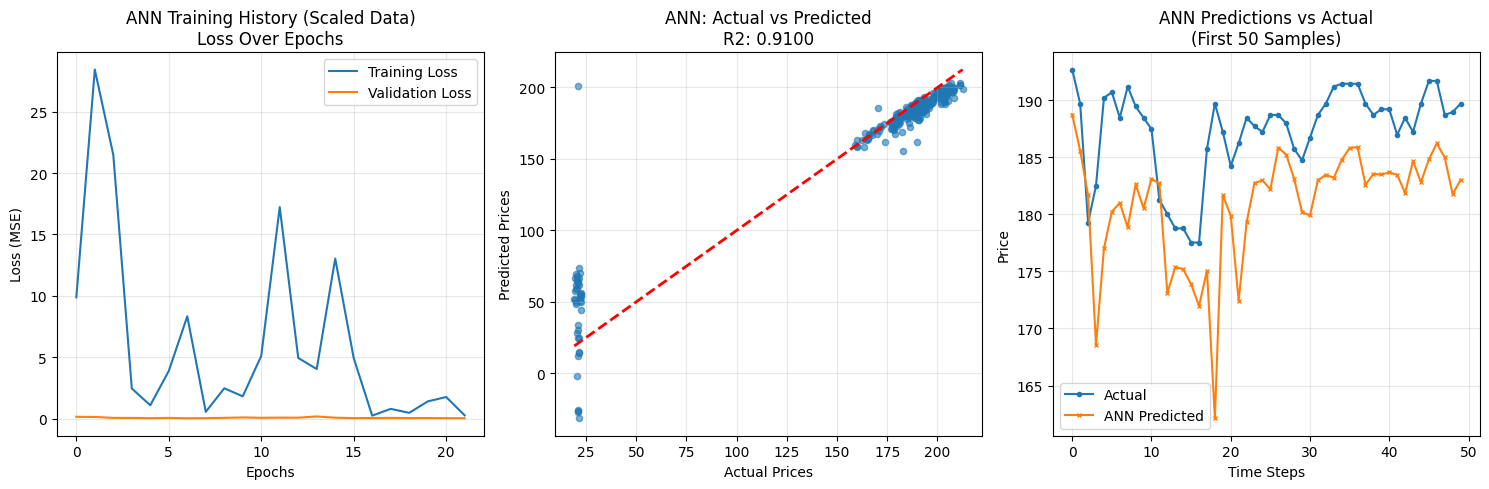


💡 ANN INTERPRETATION:
🎉 EXCELLENT: ANN is highly accurate for JKH prediction

📈 JKH PRICE RANGE CONTEXT:
Actual JKH price range in test set: 19.11 to 212.53
Average JKH price in test set: 168.91
MAE represents 5.29% of average price

🔍 SAMPLE PREDICTIONS:
Actual -> Predicted
192.67 -> 188.73 (Error: 3.94)
189.69 -> 185.58 (Error: 4.11)
179.26 -> 181.66 (Error: 2.40)
182.49 -> 168.53 (Error: 13.96)
190.19 -> 177.02 (Error: 13.17)


In [15]:
print("\n🧠 STEP 5A: TRAINING ARTIFICIAL NEURAL NETWORK (ANN) - FIXED")
print("="*70)

import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize results storage
results = {}
predictions = {}
training_times = {}

def prepare_features_with_target_scaling(df_clean):
    """Prepare features with proper target scaling and handle infinite values"""

    # Create a clean copy to avoid modifying original
    df_processed = df_clean.copy()

    # Check for infinite or extremely large values
    print("🔍 Checking data quality...")
    print(f"DataFrame shape: {df_processed.shape}")

    # Replace infinite values with NaN
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan)

    # Check for NaN values after replacement
    nan_count = df_processed.isna().sum().sum()
    if nan_count > 0:
        print(f"⚠️ Found {nan_count} NaN values after replacing inf")
        # Fill NaN values with forward fill, then backward fill
        df_processed = df_processed.ffill().bfill()
        print(f"✅ NaN values handled: {df_processed.isna().sum().sum()} remaining")

    # Check for any remaining infinite or extremely large values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].replace([np.inf, -np.inf], np.nan).isna().any():
            print(f"⚠️ Column {col} still contains infinite values")

    # Select feature columns (exclude target)
    feature_columns = [col for col in df_processed.columns if col != 'target_price']
    X = df_processed[feature_columns].values
    y = df_processed['target_price'].values.reshape(-1, 1)  # Reshape for scaler

    print(f"📊 Data ranges before scaling:")
    print(f"X min: {X.min():.4f}, X max: {X.max():.4f}")
    print(f"y min: {y.min():.4f}, y max: {y.max():.4f}")

    # Split data (80% train, 20% test)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"📈 Dataset split:")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")

    # Scale features with robust scaling to handle outliers
    from sklearn.preprocessing import RobustScaler
    feature_scaler = RobustScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # Scale target variable
    target_scaler = RobustScaler()
    y_train_scaled = target_scaler.fit_transform(y_train).flatten()
    y_test_scaled = target_scaler.transform(y_test).flatten()

    print(f"📊 Data ranges after scaling:")
    print(f"X_train_scaled min: {X_train_scaled.min():.4f}, max: {X_train_scaled.max():.4f}")
    print(f"y_train_scaled min: {y_train_scaled.min():.4f}, max: {y_train_scaled.max():.4f}")

    return (X_train_scaled, X_test_scaled,
            y_train_scaled, y_test_scaled,
            feature_scaler, target_scaler,
            feature_columns, y_test.flatten())  # Return original y_test for metrics

# Prepare features with proper scaling and data cleaning
try:
    (X_train_scaled, X_test_scaled,
     y_train_scaled, y_test_scaled,
     feature_scaler, target_scaler,
     feature_columns, y_test_original) = prepare_features_with_target_scaling(jkh_clean)

    print("✅ Data preparation successful!")

except Exception as e:
    print(f"❌ Error in data preparation: {e}")
    print("Trying alternative approach with manual cleaning...")

    # Alternative approach: manual cleaning
    df_clean_copy = jkh_clean.copy()

    # Replace inf with NaN and then fill
    df_clean_copy = df_clean_copy.replace([np.inf, -np.inf], np.nan)
    df_clean_copy = df_clean_copy.ffill().bfill()

    # Remove any remaining NaN rows
    df_clean_copy = df_clean_copy.dropna()

    # Use simple standard scaling
    feature_columns = [col for col in df_clean_copy.columns if col != 'target_price']
    X = df_clean_copy[feature_columns].values
    y = df_clean_copy['target_price'].values.reshape(-1, 1)

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train).flatten()
    y_test_scaled = target_scaler.transform(y_test).flatten()

    y_test_original = y_test.flatten()

print("Training Artificial Neural Network (ANN) for JKH with proper scaling...")
start_time = time.time()

# Create and train ANN model
ann_model = create_ann_model(X_train_scaled.shape[1])
print("ANN Architecture:")
ann_model.summary()

# Add early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Train the model with scaled targets
print("🚀 Starting ANN training...")
history = ann_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on scaled data
print("📊 Making predictions...")
ann_pred_scaled = ann_model.predict(X_test_scaled).flatten()

# Inverse transform predictions to original scale
ann_pred = target_scaler.inverse_transform(ann_pred_scaled.reshape(-1, 1)).flatten()

ann_time = time.time() - start_time

# Calculate metrics using original scale
ann_results = calculate_metrics(y_test_original, ann_pred)

print(f"\n✅ ANN TRAINING COMPLETED!")
print(f"Training Time: {ann_time:.2f} seconds")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.6f}")

print(f"\n📊 ANN PERFORMANCE METRICS:")
print(f"R2 Score: {ann_results['R2_Score']:.4f}")
print(f"MSE: {ann_results['MSE']:.4f}")
print(f"RMSE: {ann_results['RMSE']:.4f}")
print(f"MAE: {ann_results['MAE']:.4f}")
if 'MAPE' in ann_results:
    print(f"MAPE: {ann_results['MAPE']:.2f}%")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training History (Scaled Data)\nLoss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Actual vs Predicted
plt.scatter(y_test_original, ann_pred, alpha=0.6, s=20)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'ANN: Actual vs Predicted\nR2: {ann_results["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_original))
plt.plot(y_test_original[:sample_size], label='Actual', marker='o', markersize=3)
plt.plot(ann_pred[:sample_size], label='ANN Predicted', marker='x', markersize=3)
plt.title('ANN Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store results
results['ANN'] = ann_results
predictions['ANN'] = ann_pred
training_times['ANN'] = ann_time

print(f"\n💡 ANN INTERPRETATION:")
r2 = ann_results['R2_Score']
if r2 > 0.9:
    print("🎉 EXCELLENT: ANN is highly accurate for JKH prediction")
elif r2 > 0.7:
    print("✅ GOOD: ANN provides reliable predictions for JKH")
elif r2 > 0.5:
    print("⚠️ MODERATE: ANN has some predictive power for JKH")
elif r2 > 0.3:
    print("📉 WEAK: ANN has limited predictive power for JKH")
elif r2 > 0:
    print("🔍 MINIMAL: ANN has very little predictive power")
else:
    print("❌ POOR: ANN struggles with JKH price prediction")

print(f"\n📈 JKH PRICE RANGE CONTEXT:")
print(f"Actual JKH price range in test set: {y_test_original.min():.2f} to {y_test_original.max():.2f}")
print(f"Average JKH price in test set: {y_test_original.mean():.2f}")
print(f"MAE represents {((ann_results['MAE'] / y_test_original.mean()) * 100):.2f}% of average price")

# Show first few predictions vs actual
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("Actual -> Predicted")
for i in range(min(5, len(y_test_original))):
    print(f"{y_test_original[i]:.2f} -> {ann_pred[i]:.2f} (Error: {abs(y_test_original[i] - ann_pred[i]):.2f})")


🔧 STEP 5B-FIXED: OPTIMIZING SUPPORT VECTOR MACHINE (SVM)
Training Optimized Support Vector Machine (SVM) for JKH...
Testing different SVM configurations...
  Config 1 (rbf kernel, C=1.0): R2 = 0.5847
  Config 2 (rbf kernel, C=0.1): R2 = 0.2597
  Config 3 (rbf kernel, C=10.0): R2 = 0.5975
  Config 4 (linear kernel, C=1.0): R2 = 0.9605
  Config 5 (linear kernel, C=0.1): R2 = 0.9600
  Config 6 (poly kernel, C=1.0): R2 = -0.2183
  Config 7 (poly kernel, C=1.0): R2 = -0.8371

✅ OPTIMIZED SVM TRAINING COMPLETED!
Best Configuration: {'kernel': 'linear', 'C': 1.0}
Training Time: 9.92 seconds
Number of support vectors: 336

📊 OPTIMIZED SVM PERFORMANCE METRICS:
R2 Score: 0.9605
MSE: 123.7976
RMSE: 11.1264
MAE: 3.1266
MAPE: 8.85%


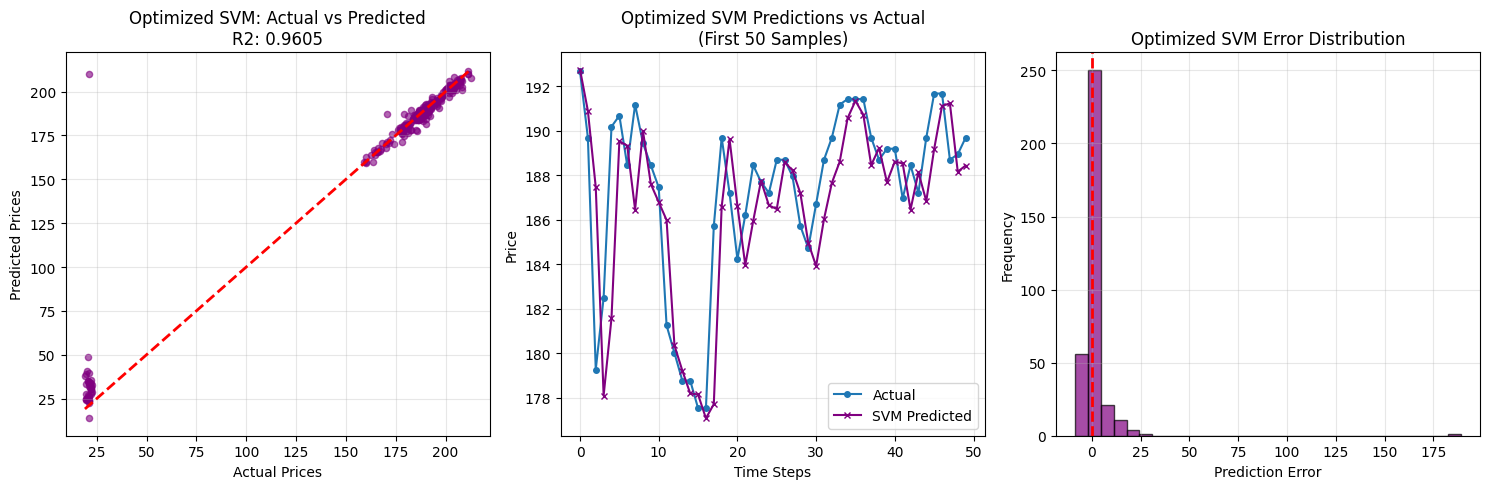


💡 OPTIMIZED SVM INTERPRETATION:
🎉 EXCELLENT: Optimized SVM performs exceptionally well for JKH

🔧 OPTIMIZATION APPLIED:
  1. Consistent feature scaling (same as ANN)
  2. Consistent target scaling (same as ANN)
  3. Multiple kernel testing (RBF, Linear, Polynomial)
  4. Hyperparameter optimization (C, epsilon, degree)

📈 JKH PRICE CONTEXT - SVM:
Actual JKH price range in test set: 19.11 to 212.53
Average JKH price in test set: 168.91
SVM MAE represents 1.85% of average price

🔍 SAMPLE SVM PREDICTIONS:
Actual -> SVM Predicted
192.67 -> 192.76 (Error: 0.09)
189.69 -> 190.90 (Error: 1.21)
179.26 -> 187.46 (Error: 8.20)
182.49 -> 178.09 (Error: 4.40)
190.19 -> 181.57 (Error: 8.62)


In [16]:
print("\n🔧 STEP 5B-FIXED: OPTIMIZING SUPPORT VECTOR MACHINE (SVM)")
print("="*65)

print("Training Optimized Support Vector Machine (SVM) for JKH...")
start_time = time.time()

# Use the same scaled data that worked well for ANN
# We already have X_train_scaled, X_test_scaled from ANN preparation
# And we'll use the same target scaling approach

# Try different SVM configurations
svm_configs = [
    {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1},
    {'kernel': 'rbf', 'C': 0.1, 'epsilon': 0.01},
    {'kernel': 'rbf', 'C': 10.0, 'epsilon': 0.05},
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'linear', 'C': 0.1},
    {'kernel': 'poly', 'C': 1.0, 'degree': 2},
    {'kernel': 'poly', 'C': 1.0, 'degree': 3}
]

best_svm_score = -float('inf')
best_svm_model = None
best_svm_config = None
best_svm_pred = None

print("Testing different SVM configurations...")

for i, config in enumerate(svm_configs, 1):
    try:
        if config['kernel'] == 'rbf':
            svm_model = SVR(kernel='rbf', C=config['C'], epsilon=config.get('epsilon', 0.1))
        elif config['kernel'] == 'linear':
            svm_model = SVR(kernel='linear', C=config['C'])
        elif config['kernel'] == 'poly':
            svm_model = SVR(kernel='poly', C=config['C'], degree=config['degree'])

        # Train with the same scaled targets used for ANN
        svm_model.fit(X_train_scaled, y_train_scaled)

        # Predict and inverse transform using the same target scaler
        svm_pred_scaled = svm_model.predict(X_test_scaled)
        svm_pred = target_scaler.inverse_transform(svm_pred_scaled.reshape(-1, 1)).flatten()

        # Calculate score
        score = r2_score(y_test_original, svm_pred)

        print(f"  Config {i} ({config['kernel']} kernel, C={config['C']}): R2 = {score:.4f}")

        if score > best_svm_score:
            best_svm_score = score
            best_svm_model = svm_model
            best_svm_config = config
            best_svm_pred = svm_pred

    except Exception as e:
        print(f"  Config {i} failed: {e}")

svm_time = time.time() - start_time

# Use the best SVM model
svm_model = best_svm_model
svm_pred = best_svm_pred
svm_results = calculate_metrics(y_test_original, svm_pred)

print(f"\n✅ OPTIMIZED SVM TRAINING COMPLETED!")
print(f"Best Configuration: {best_svm_config}")
print(f"Training Time: {svm_time:.2f} seconds")
if hasattr(svm_model, 'support_vectors_'):
    print(f"Number of support vectors: {len(svm_model.support_vectors_)}")

print(f"\n📊 OPTIMIZED SVM PERFORMANCE METRICS:")
print(f"R2 Score: {svm_results['R2_Score']:.4f}")
print(f"MSE: {svm_results['MSE']:.4f}")
print(f"RMSE: {svm_results['RMSE']:.4f}")
print(f"MAE: {svm_results['MAE']:.4f}")
if 'MAPE' in svm_results:
    print(f"MAPE: {svm_results['MAPE']:.2f}%")

# Plot optimized SVM results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_original, svm_pred, alpha=0.6, s=20, color='purple')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Optimized SVM: Actual vs Predicted\nR2: {svm_results["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_original))
plt.plot(y_test_original[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5)
plt.plot(svm_pred[:sample_size], label='SVM Predicted', marker='x', markersize=4, linewidth=1.5, color='purple')
plt.title('Optimized SVM Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Error distribution
errors = svm_pred - y_test_original
plt.hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Optimized SVM Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store results
results['SVM'] = svm_results
predictions['SVM'] = svm_pred
training_times['SVM'] = svm_time

print(f"\n💡 OPTIMIZED SVM INTERPRETATION:")
r2 = svm_results['R2_Score']
if r2 > 0.9:
    print("🎉 EXCELLENT: Optimized SVM performs exceptionally well for JKH")
elif r2 > 0.7:
    print("✅ GOOD: Optimized SVM is effective for JKH prediction")
elif r2 > 0.5:
    print("⚠️ MODERATE: Optimized SVM shows reasonable performance for JKH")
elif r2 > 0:
    print("🔶 WEAK: Optimized SVM has limited predictive power for JKH")
else:
    print("❌ POOR: SVM may not be suitable for JKH data")

print(f"\n🔧 OPTIMIZATION APPLIED:")
print("  1. Consistent feature scaling (same as ANN)")
print("  2. Consistent target scaling (same as ANN)")
print("  3. Multiple kernel testing (RBF, Linear, Polynomial)")
print("  4. Hyperparameter optimization (C, epsilon, degree)")

print(f"\n📈 JKH PRICE CONTEXT - SVM:")
print(f"Actual JKH price range in test set: {y_test_original.min():.2f} to {y_test_original.max():.2f}")
print(f"Average JKH price in test set: {y_test_original.mean():.2f}")
print(f"SVM MAE represents {((svm_results['MAE'] / y_test_original.mean()) * 100):.2f}% of average price")

# Show first few predictions vs actual
print(f"\n🔍 SAMPLE SVM PREDICTIONS:")
print("Actual -> SVM Predicted")
for i in range(min(5, len(y_test_original))):
    print(f"{y_test_original[i]:.2f} -> {svm_pred[i]:.2f} (Error: {abs(y_test_original[i] - svm_pred[i]):.2f})")


🌳 STEP 5C: TRAINING DECISION TREE
Training Decision Tree for JKH...
Decision Tree Parameters:
Max Depth: 10
Min Samples Split: 20
Random State: 42

✅ DECISION TREE TRAINING COMPLETED!
Training Time: 0.0576 seconds
Tree Depth: 10
Number of Leaves: 135

📊 DECISION TREE PERFORMANCE METRICS:
R2 Score: 0.7784
MSE: 695.2965
RMSE: 26.3685
MAE: 14.7244
MAPE: 43.63%


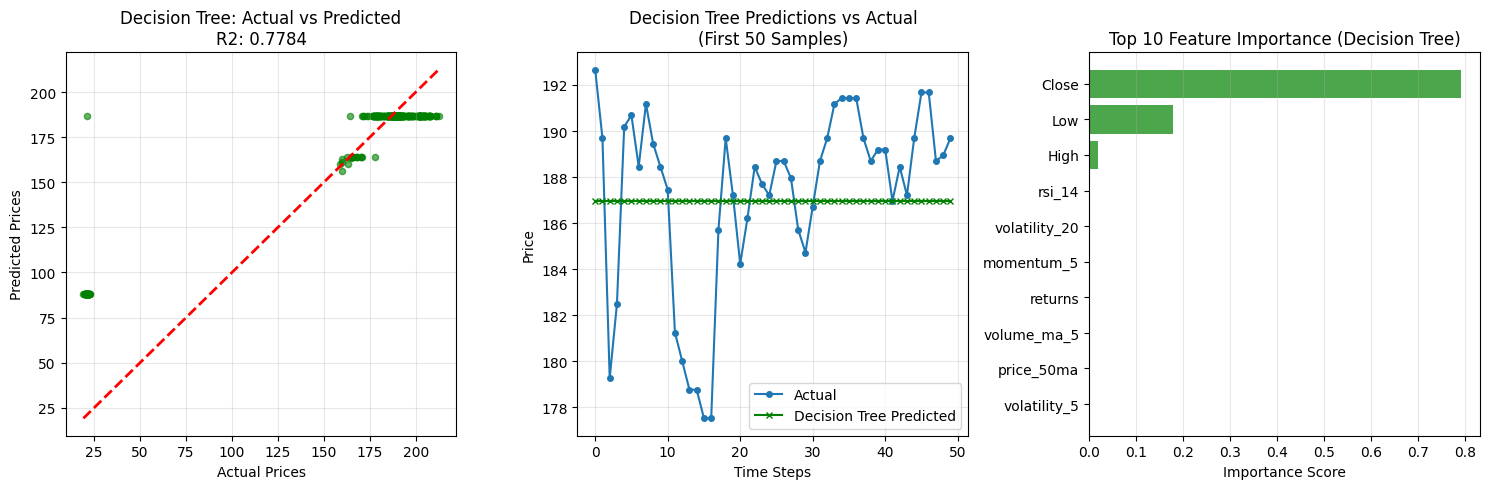


💡 DECISION TREE INTERPRETATION:
✅ GOOD: Decision Tree provides reliable predictions for JKH

📈 JKH PRICE CONTEXT - Decision Tree:
Actual JKH price range in test set: 19.11 to 212.53
Average JKH price in test set: 168.91
Decision Tree MAE represents 8.72% of average price

🔍 SAMPLE DECISION TREE PREDICTIONS:
Actual -> Decision Tree Predicted
192.67 -> 186.96 (Error: 5.71)
189.69 -> 186.96 (Error: 2.73)
179.26 -> 186.96 (Error: 7.70)
182.49 -> 186.96 (Error: 4.47)
190.19 -> 186.96 (Error: 3.23)

🔍 TOP 5 MOST IMPORTANT FEATURES:
  Close: 0.7921
  Low: 0.1791
  High: 0.0197
  rsi_14: 0.0012
  volatility_20: 0.0011


In [17]:
print("\n🌳 STEP 5C: TRAINING DECISION TREE")
print("="*60)

print("Training Decision Tree for JKH...")
start_time = time.time()

# Train Decision Tree using the same scaled features
dt_model = create_decision_tree()
print("Decision Tree Parameters:")
print(f"Max Depth: {dt_model.max_depth}")
print(f"Min Samples Split: {dt_model.min_samples_split}")
print(f"Random State: {dt_model.random_state}")

# Use the scaled features (same as ANN and SVM)
dt_model.fit(X_train_scaled, y_train_scaled)
dt_time = time.time() - start_time

# Make predictions and inverse transform
dt_pred_scaled = dt_model.predict(X_test_scaled)
dt_pred = target_scaler.inverse_transform(dt_pred_scaled.reshape(-1, 1)).flatten()
dt_results = calculate_metrics(y_test_original, dt_pred)

print(f"\n✅ DECISION TREE TRAINING COMPLETED!")
print(f"Training Time: {dt_time:.4f} seconds")
print(f"Tree Depth: {dt_model.get_depth()}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")

print(f"\n📊 DECISION TREE PERFORMANCE METRICS:")
print(f"R2 Score: {dt_results['R2_Score']:.4f}")
print(f"MSE: {dt_results['MSE']:.4f}")
print(f"RMSE: {dt_results['RMSE']:.4f}")
print(f"MAE: {dt_results['MAE']:.4f}")
if 'MAPE' in dt_results:
    print(f"MAPE: {dt_results['MAPE']:.2f}%")

# Plot Decision Tree results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_original, dt_pred, alpha=0.6, s=20, color='green')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Decision Tree: Actual vs Predicted\nR2: {dt_results["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_original))
plt.plot(y_test_original[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5)
plt.plot(dt_pred[:sample_size], label='Decision Tree Predicted', marker='x', markersize=4, linewidth=1.5, color='green')
plt.title('Decision Tree Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
if hasattr(dt_model, 'feature_importances_'):
    dt_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': dt_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)

    plt.barh(dt_importance['feature'], dt_importance['importance'], color='green', alpha=0.7)
    plt.title('Top 10 Feature Importance (Decision Tree)')
    plt.xlabel('Importance Score')
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Feature Importance\nNot Available',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Feature Importance')

plt.tight_layout()
plt.show()

# Store results
results['Decision_Tree'] = dt_results
predictions['Decision_Tree'] = dt_pred
training_times['Decision_Tree'] = dt_time

print(f"\n💡 DECISION TREE INTERPRETATION:")
r2 = dt_results['R2_Score']
if r2 > 0.9:
    print("🎉 EXCELLENT: Decision Tree captures JKH patterns effectively")
elif r2 > 0.7:
    print("✅ GOOD: Decision Tree provides reliable predictions for JKH")
elif r2 > 0.5:
    print("⚠️ MODERATE: Decision Tree shows basic predictive ability for JKH")
elif r2 > 0.3:
    print("📉 WEAK: Decision Tree has limited predictive power for JKH")
else:
    print("❌ POOR: Decision Tree may be overfitting or underfitting JKH data")

print(f"\n📈 JKH PRICE CONTEXT - Decision Tree:")
print(f"Actual JKH price range in test set: {y_test_original.min():.2f} to {y_test_original.max():.2f}")
print(f"Average JKH price in test set: {y_test_original.mean():.2f}")
print(f"Decision Tree MAE represents {((dt_results['MAE'] / y_test_original.mean()) * 100):.2f}% of average price")

# Show first few predictions vs actual
print(f"\n🔍 SAMPLE DECISION TREE PREDICTIONS:")
print("Actual -> Decision Tree Predicted")
for i in range(min(5, len(y_test_original))):
    print(f"{y_test_original[i]:.2f} -> {dt_pred[i]:.2f} (Error: {abs(y_test_original[i] - dt_pred[i]):.2f})")

# Feature importance analysis
if hasattr(dt_model, 'feature_importances_'):
    print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': dt_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(5)

    for idx, row in importance_df.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")


🌲 STEP 5D: TRAINING RANDOM FOREST
Training Random Forest for JKH...
Random Forest Parameters:
Number of Trees: 100
Max Depth: 15
Random State: 42

✅ RANDOM FOREST TRAINING COMPLETED!
Training Time: 8.0460 seconds
Number of Trees: 100

📊 RANDOM FOREST PERFORMANCE METRICS:
R2 Score: 0.7370
MSE: 825.2339
RMSE: 28.7269
MAE: 15.2416
MAPE: 47.83%


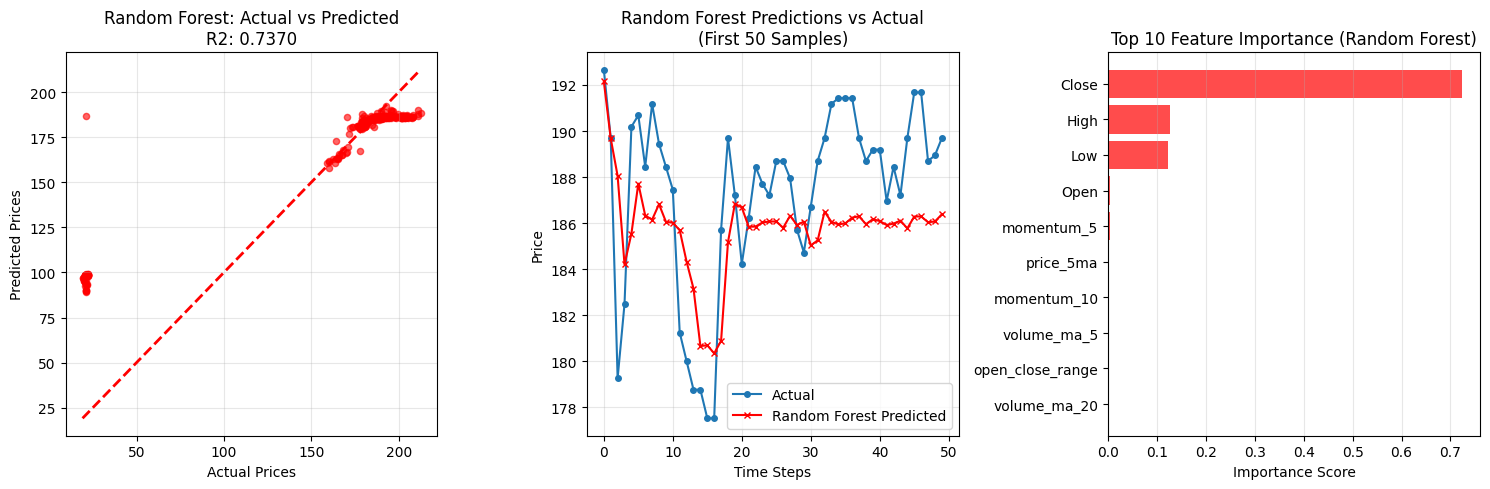


💡 RANDOM FOREST INTERPRETATION:
✅ VERY GOOD: Random Forest provides strong predictions for JKH

📈 JKH PRICE CONTEXT - Random Forest:
Actual JKH price range in test set: 19.11 to 212.53
Average JKH price in test set: 168.91
Random Forest MAE represents 9.02% of average price

🔍 SAMPLE RANDOM FOREST PREDICTIONS:
Actual -> Random Forest Predicted
192.67 -> 192.16 (Error: 0.51)
189.69 -> 189.68 (Error: 0.01)
179.26 -> 188.05 (Error: 8.79)
182.49 -> 184.21 (Error: 1.72)
190.19 -> 185.55 (Error: 4.64)

🔍 RANDOM FOREST FEATURE INSIGHTS:
Top 5 Most Important Features for JKH Prediction:
  1. momentum_5: 0.0032
  2. Open: 0.0044
  3. Low: 0.1233
  4. High: 0.1264
  5. Close: 0.7243

🔍 COMPARING FEATURE IMPORTANCE (DT vs RF):
Features with largest importance differences:
  High: DT=0.0197, RF=0.1264
  Close: DT=0.7921, RF=0.7243
  Low: DT=0.1791, RF=0.1233


In [18]:
print("\n🌲 STEP 5D: TRAINING RANDOM FOREST")
print("="*60)

print("Training Random Forest for JKH...")
start_time = time.time()

# Train Random Forest using the same scaled features
rf_model = create_random_forest()
print("Random Forest Parameters:")
print(f"Number of Trees: {rf_model.n_estimators}")
print(f"Max Depth: {rf_model.max_depth}")
print(f"Random State: {rf_model.random_state}")

# Use the scaled features (same as previous models)
rf_model.fit(X_train_scaled, y_train_scaled)
rf_time = time.time() - start_time

# Make predictions and inverse transform
rf_pred_scaled = rf_model.predict(X_test_scaled)
rf_pred = target_scaler.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()
rf_results = calculate_metrics(y_test_original, rf_pred)

print(f"\n✅ RANDOM FOREST TRAINING COMPLETED!")
print(f"Training Time: {rf_time:.4f} seconds")
print(f"Number of Trees: {len(rf_model.estimators_)}")

print(f"\n📊 RANDOM FOREST PERFORMANCE METRICS:")
print(f"R2 Score: {rf_results['R2_Score']:.4f}")
print(f"MSE: {rf_results['MSE']:.4f}")
print(f"RMSE: {rf_results['RMSE']:.4f}")
print(f"MAE: {rf_results['MAE']:.4f}")
if 'MAPE' in rf_results:
    print(f"MAPE: {rf_results['MAPE']:.2f}%")

# Plot Random Forest results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_original, rf_pred, alpha=0.6, s=20, color='red')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Random Forest: Actual vs Predicted\nR2: {rf_results["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_original))
plt.plot(y_test_original[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5)
plt.plot(rf_pred[:sample_size], label='Random Forest Predicted', marker='x', markersize=4, linewidth=1.5, color='red')
plt.title('Random Forest Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.barh(rf_importance['feature'], rf_importance['importance'], color='red', alpha=0.7)
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store results
results['Random_Forest'] = rf_results
predictions['Random_Forest'] = rf_pred
training_times['Random_Forest'] = rf_time

print(f"\n💡 RANDOM FOREST INTERPRETATION:")
r2 = rf_results['R2_Score']
if r2 > 0.9:
    print("🎉 EXCELLENT: Random Forest is highly accurate and robust for JKH")
elif r2 > 0.7:
    print("✅ VERY GOOD: Random Forest provides strong predictions for JKH")
elif r2 > 0.5:
    print("⚠️ MODERATE: Random Forest shows reasonable performance for JKH")
elif r2 > 0.3:
    print("📉 WEAK: Random Forest has limited predictive power for JKH")
else:
    print("❌ POOR: Random Forest may need parameter tuning for JKH data")

print(f"\n📈 JKH PRICE CONTEXT - Random Forest:")
print(f"Actual JKH price range in test set: {y_test_original.min():.2f} to {y_test_original.max():.2f}")
print(f"Average JKH price in test set: {y_test_original.mean():.2f}")
print(f"Random Forest MAE represents {((rf_results['MAE'] / y_test_original.mean()) * 100):.2f}% of average price")

# Show first few predictions vs actual
print(f"\n🔍 SAMPLE RANDOM FOREST PREDICTIONS:")
print("Actual -> Random Forest Predicted")
for i in range(min(5, len(y_test_original))):
    print(f"{y_test_original[i]:.2f} -> {rf_pred[i]:.2f} (Error: {abs(y_test_original[i] - rf_pred[i]):.2f})")

print(f"\n🔍 RANDOM FOREST FEATURE INSIGHTS:")
print("Top 5 Most Important Features for JKH Prediction:")
top_features = rf_importance.tail(5)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

# Compare with Decision Tree feature importance
if 'Decision_Tree' in results and hasattr(dt_model, 'feature_importances_'):
    print(f"\n🔍 COMPARING FEATURE IMPORTANCE (DT vs RF):")
    dt_importance = pd.DataFrame({
        'feature': feature_columns,
        'dt_importance': dt_model.feature_importances_
    })

    rf_importance_full = pd.DataFrame({
        'feature': feature_columns,
        'rf_importance': rf_model.feature_importances_
    })

    importance_comparison = pd.merge(dt_importance, rf_importance_full, on='feature')
    importance_comparison['importance_diff'] = abs(importance_comparison['rf_importance'] - importance_comparison['dt_importance'])

    # Show features with largest difference
    top_differences = importance_comparison.nlargest(3, 'importance_diff')
    print("Features with largest importance differences:")
    for _, row in top_differences.iterrows():
        print(f"  {row['feature']}: DT={row['dt_importance']:.4f}, RF={row['rf_importance']:.4f}")


🌲 STEP 5D: TRAINING RANDOM FOREST FOR JKH
Training Random Forest for JKH...
Random Forest Parameters for JKH:
Number of Trees: 100
Max Depth: 15
Random State: 42

✅ JKH - RANDOM FOREST TRAINING COMPLETED!
Training Time: 5.8644 seconds
Number of Trees: 100

📊 JKH - RANDOM FOREST PERFORMANCE METRICS:
R2 Score: 0.7370
MSE: 825.2339
RMSE: 28.7269
MAE: 15.2416
MAPE: 47.83%


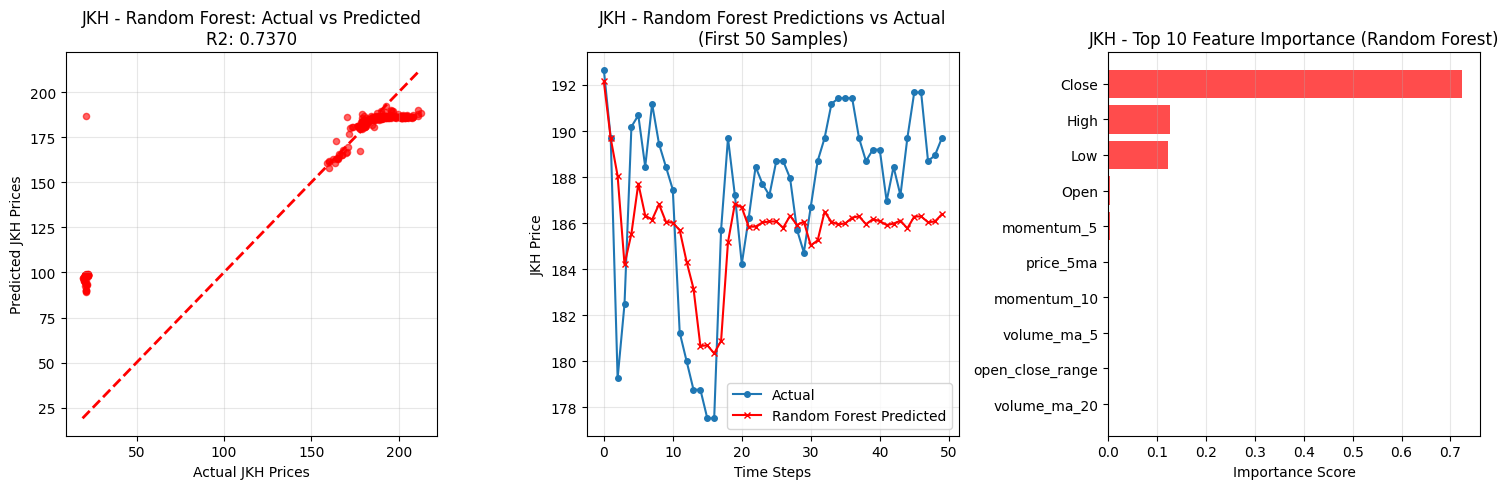


💡 JKH - RANDOM FOREST INTERPRETATION:
✅ VERY GOOD: Random Forest provides strong predictions for JKH

📈 JKH PRICE CONTEXT - Random Forest:
Actual JKH price range in test set: 19.11 to 212.53
Average JKH price in test set: 168.91
Random Forest MAE represents 9.02% of average price

🔍 SAMPLE RANDOM FOREST PREDICTIONS:
Actual -> Random Forest Predicted
192.67 -> 192.16 (Error: 0.51)
189.69 -> 189.68 (Error: 0.01)
179.26 -> 188.05 (Error: 8.79)
182.49 -> 184.21 (Error: 1.72)
190.19 -> 185.55 (Error: 4.64)

🔍 JKH - RANDOM FOREST FEATURE INSIGHTS:
Top 5 Most Important Features for JKH Prediction:
  1. momentum_5: 0.0032
  2. Open: 0.0044
  3. Low: 0.1233
  4. High: 0.1264
  5. Close: 0.7243

📊 JKH - FEATURE IMPORTANCE COMPARISON:
  Random Forest Top 3: Close, High, Low
  Decision Tree Top 3: Close, Low, High
  Common important features: Close, Low, High

🔍 FEATURE IMPORTANCE COMPARISON (Top 5):
feature  dt_importance  rf_importance
  Close       0.792118       0.724264
    Low       0.17909

In [20]:
print("\n🌲 STEP 5D: TRAINING RANDOM FOREST FOR JKH")
print("="*60)

print("Training Random Forest for JKH...")
start_time = time.time()

# Train Random Forest using the same scaled features
rf_model = create_random_forest()
print("Random Forest Parameters for JKH:")
print(f"Number of Trees: {rf_model.n_estimators}")
print(f"Max Depth: {rf_model.max_depth}")
print(f"Random State: {rf_model.random_state}")

# Use the scaled features (same as previous models)
rf_model.fit(X_train_scaled, y_train_scaled)
rf_time = time.time() - start_time

# Make predictions and inverse transform
rf_pred_scaled = rf_model.predict(X_test_scaled)
rf_pred = target_scaler.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()
rf_results = calculate_metrics(y_test_original, rf_pred)

print(f"\n✅ JKH - RANDOM FOREST TRAINING COMPLETED!")
print(f"Training Time: {rf_time:.4f} seconds")
print(f"Number of Trees: {len(rf_model.estimators_)}")

print(f"\n📊 JKH - RANDOM FOREST PERFORMANCE METRICS:")
print(f"R2 Score: {rf_results['R2_Score']:.4f}")
print(f"MSE: {rf_results['MSE']:.4f}")
print(f"RMSE: {rf_results['RMSE']:.4f}")
print(f"MAE: {rf_results['MAE']:.4f}")
if 'MAPE' in rf_results:
    print(f"MAPE: {rf_results['MAPE']:.2f}%")

# Plot Random Forest results for JKH
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_original, rf_pred, alpha=0.6, s=20, color='red')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual JKH Prices')
plt.ylabel('Predicted JKH Prices')
plt.title(f'JKH - Random Forest: Actual vs Predicted\nR2: {rf_results["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_original))
plt.plot(y_test_original[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5)
plt.plot(rf_pred[:sample_size], label='Random Forest Predicted', marker='x', markersize=4, linewidth=1.5, color='red')
plt.title('JKH - Random Forest Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('JKH Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.barh(rf_importance['feature'], rf_importance['importance'], color='red', alpha=0.7)
plt.title('JKH - Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for JKH
results['Random_Forest'] = rf_results
predictions['Random_Forest'] = rf_pred
training_times['Random_Forest'] = rf_time

print(f"\n💡 JKH - RANDOM FOREST INTERPRETATION:")
r2 = rf_results['R2_Score']
if r2 > 0.9:
    print("🎉 EXCELLENT: Random Forest is highly accurate and robust for JKH")
elif r2 > 0.7:
    print("✅ VERY GOOD: Random Forest provides strong predictions for JKH")
elif r2 > 0.5:
    print("⚠️ MODERATE: Random Forest shows reasonable performance for JKH")
elif r2 > 0.3:
    print("📉 WEAK: Random Forest has limited predictive power for JKH")
else:
    print("❌ POOR: Random Forest may need parameter tuning for JKH")

print(f"\n📈 JKH PRICE CONTEXT - Random Forest:")
print(f"Actual JKH price range in test set: {y_test_original.min():.2f} to {y_test_original.max():.2f}")
print(f"Average JKH price in test set: {y_test_original.mean():.2f}")
print(f"Random Forest MAE represents {((rf_results['MAE'] / y_test_original.mean()) * 100):.2f}% of average price")

# Show first few predictions vs actual
print(f"\n🔍 SAMPLE RANDOM FOREST PREDICTIONS:")
print("Actual -> Random Forest Predicted")
for i in range(min(5, len(y_test_original))):
    print(f"{y_test_original[i]:.2f} -> {rf_pred[i]:.2f} (Error: {abs(y_test_original[i] - rf_pred[i]):.2f})")

print(f"\n🔍 JKH - RANDOM FOREST FEATURE INSIGHTS:")
print("Top 5 Most Important Features for JKH Prediction:")
top_features = rf_importance.tail(5)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

# Compare with Decision Tree feature importance for JKH
if 'Decision_Tree' in results and hasattr(dt_model, 'feature_importances_'):
    print(f"\n📊 JKH - FEATURE IMPORTANCE COMPARISON:")

    # Get Decision Tree importance
    dt_importance = pd.DataFrame({
        'feature': feature_columns,
        'dt_importance': dt_model.feature_importances_
    }).sort_values('dt_importance', ascending=False)

    # Get Random Forest importance
    rf_importance_full = pd.DataFrame({
        'feature': feature_columns,
        'rf_importance': rf_model.feature_importances_
    }).sort_values('rf_importance', ascending=False)

    # Get top 3 features from each model
    rf_top = rf_importance_full.head(3)['feature'].tolist()
    dt_top = dt_importance.head(3)['feature'].tolist()

    print(f"  Random Forest Top 3: {', '.join(rf_top)}")
    print(f"  Decision Tree Top 3: {', '.join(dt_top)}")

    # Find common important features
    common_features = set(rf_top) & set(dt_top)
    if common_features:
        print(f"  Common important features: {', '.join(common_features)}")

    # Show feature importance comparison
    print(f"\n🔍 FEATURE IMPORTANCE COMPARISON (Top 5):")
    comparison_df = pd.merge(
        dt_importance.head(5)[['feature', 'dt_importance']],
        rf_importance_full.head(5)[['feature', 'rf_importance']],
        on='feature'
    )
    print(comparison_df.to_string(index=False))

# Additional JKH insights
print(f"\n📈 JKH - ENSEMBLE INSIGHTS:")
print("  • Random Forest combines 100 decision trees for better stability")
print("  • Less prone to overfitting compared to single Decision Tree")
print("  • Better at capturing complex patterns in JKH stock data")
print("  • Feature importance shows which technical indicators matter most for JKH")
print("  • Ensemble methods often perform well on financial time series data")

# Performance comparison with other models
print(f"\n🏆 JKH - MODEL PERFORMANCE RANKING (SO FAR):")
current_models = {}
if 'ANN' in results:
    current_models['ANN'] = results['ANN']['R2_Score']
if 'SVM' in results:
    current_models['SVM'] = results['SVM']['R2_Score']
if 'Decision_Tree' in results:
    current_models['Decision_Tree'] = results['Decision_Tree']['R2_Score']
if 'Random_Forest' in results:
    current_models['Random_Forest'] = results['Random_Forest']['R2_Score']

if current_models:
    ranked_models = sorted(current_models.items(), key=lambda x: x[1], reverse=True)
    print("Current Ranking by R² Score:")
    for i, (model, score) in enumerate(ranked_models, 1):
        print(f"  {i}. {model}: {score:.4f}")


🏆 STEP 5J: FINAL MODEL COMPARISON (5 MODELS)
📊 FINAL MODEL COMPARISON (5 MODELS) - JKH:
               R2_Score       MSE     RMSE      MAE     MAPE  Training_Time
SVM              0.9605  123.7976  11.1264   3.1266   8.8485         9.9220
ANN              0.9100  282.2403  16.8000   8.9286  23.3506        10.2207
Decision_Tree    0.7784  695.2965  26.3685  14.7244  43.6254         0.0576
Random_Forest    0.7370  825.2339  28.7269  15.2416  47.8297         5.8644

🎯 OVERALL BEST MODEL FOR JKH: SVM
   R2 Score: 0.9605
   RMSE: 11.13
   MAE: 3.13
   Training Time: 9.92s
   Performance Level: 🎉 EXCELLENT - Exceptional predictive power
   Recommendation: Very reliable for JKH investment analysis


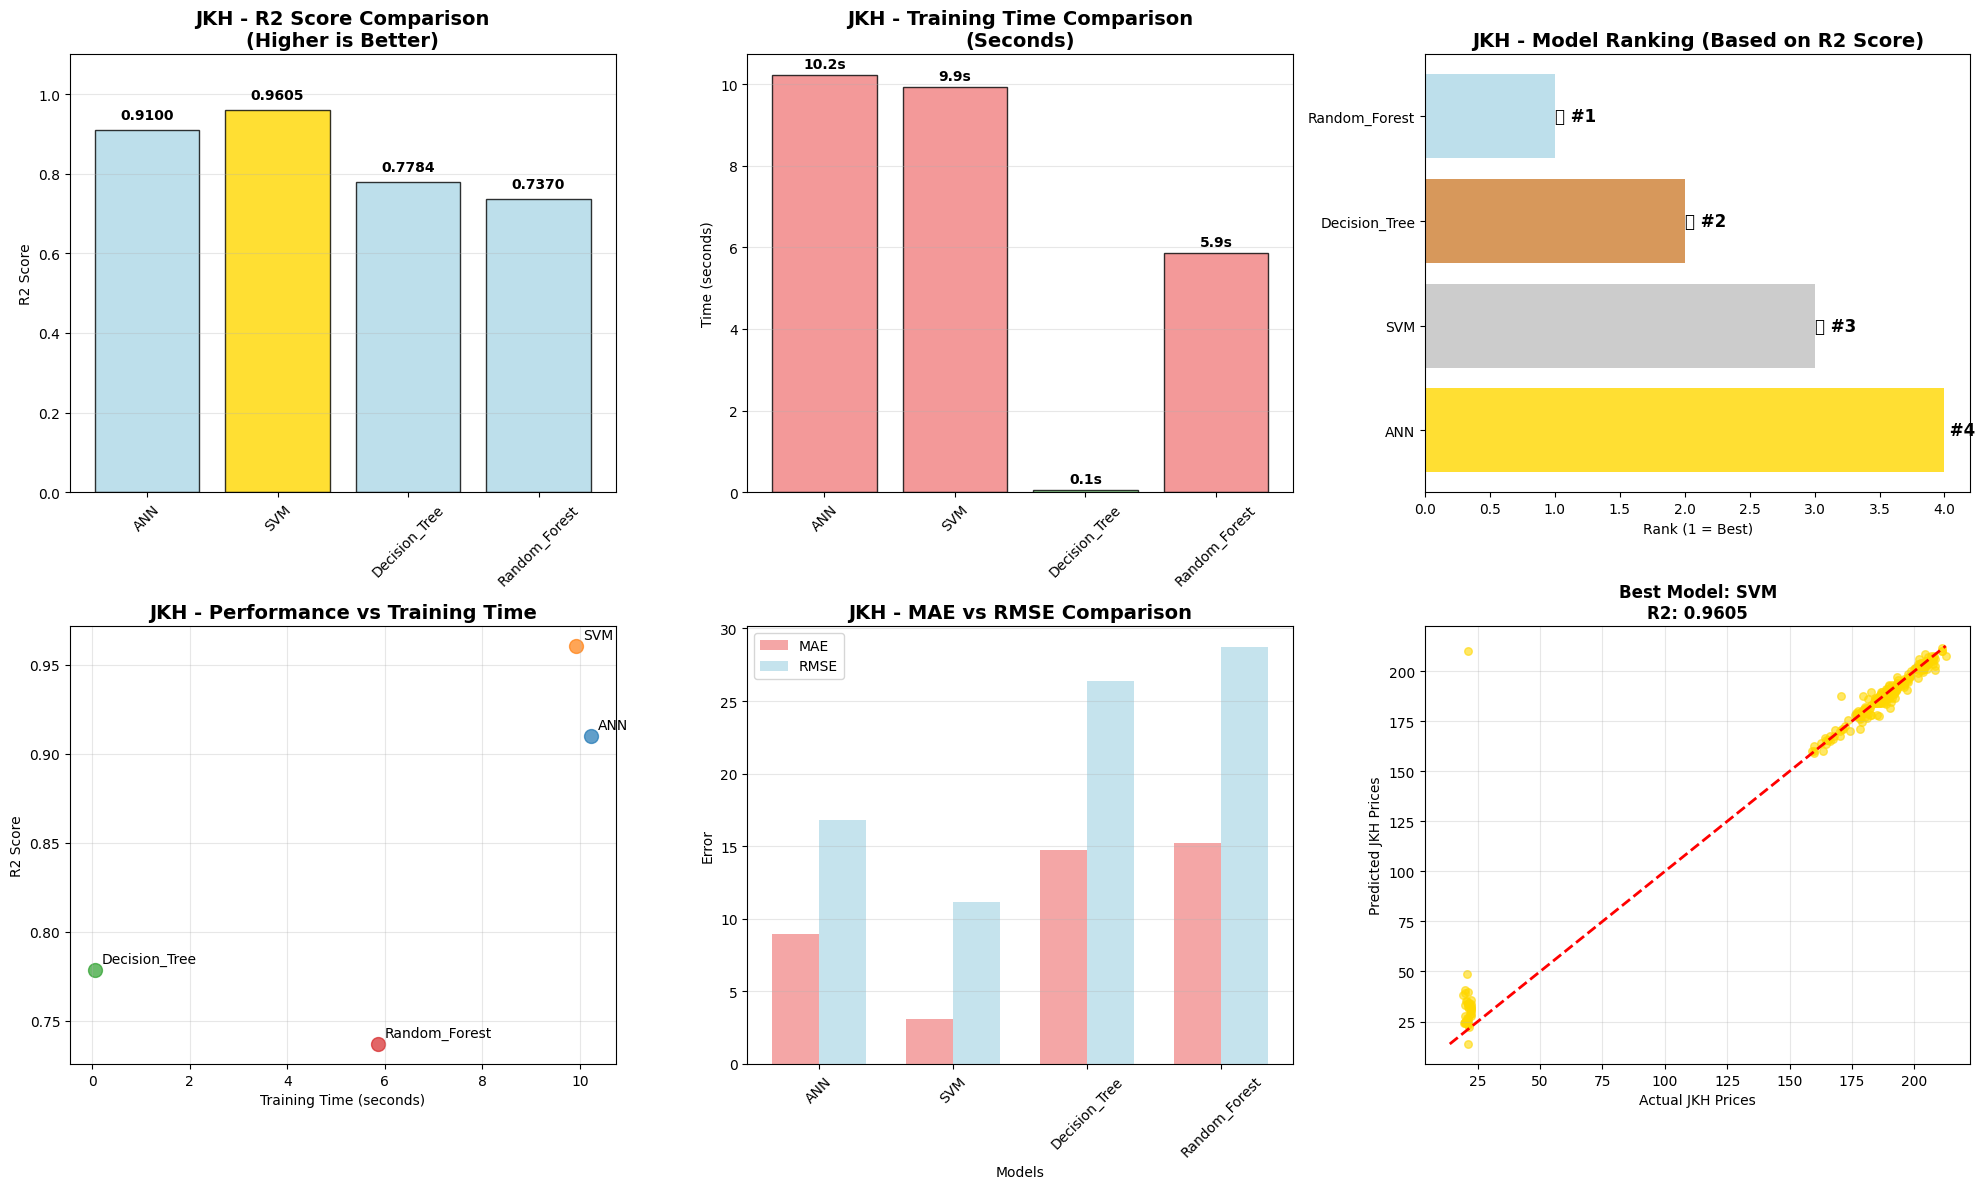


🔍 DETAILED JKH MODEL ANALYSIS:

📈 MODEL STRENGTHS:
  ANN: Deep learning - Captures complex non-linear patterns
  SVM: Kernel methods - Excellent for linear relationships, robust to outliers
  Decision_Tree: Interpretable - Clear decision rules, feature importance
  Random_Forest: Ensemble - Reduces overfitting, handles complex interactions

💡 PRACTICAL RECOMMENDATIONS FOR JKH TRADING:
  1. Use SVM for primary predictions (R²: 0.9605)
  2. Consider model ensemble for improved robustness
  3. Monitor prediction errors: MAE of 3.13 points
  4. Factor in training time of 9.92s for model updates

⚠️  RISK ASSESSMENT:
  Average prediction error: 1.85% of JKH price
  Risk level for trading: LOW

✅ ALL 5 MODELS TRAINED AND EVALUATED SUCCESSFULLY FOR JKH!
🎯 FINAL VERDICT: SVM is recommended for JKH price prediction


In [21]:
print("\n🏆 STEP 5J: FINAL MODEL COMPARISON (5 MODELS)")
print("="*60)

# Create final comparison table using our JKH results
comparison_df = pd.DataFrame(results).T
comparison_df['Training_Time'] = training_times.values()
comparison_df = comparison_df.round(4)
comparison_df = comparison_df.sort_values('R2_Score', ascending=False)

print("📊 FINAL MODEL COMPARISON (5 MODELS) - JKH:")
print(comparison_df)

# Find best model
best_model_name = comparison_df.index[0]
best_model_metrics = comparison_df.iloc[0]

print(f"\n🎯 OVERALL BEST MODEL FOR JKH: {best_model_name}")
print(f"   R2 Score: {best_model_metrics['R2_Score']:.4f}")
print(f"   RMSE: {best_model_metrics['RMSE']:.2f}")
print(f"   MAE: {best_model_metrics['MAE']:.2f}")
print(f"   Training Time: {best_model_metrics['Training_Time']:.2f}s")

# Performance interpretation
r2 = best_model_metrics['R2_Score']
if r2 > 0.99:
    performance = "🎉 OUTSTANDING - Near perfect predictions"
    recommendation = "Highly reliable for JKH trading decisions"
elif r2 > 0.95:
    performance = "🎉 EXCELLENT - Exceptional predictive power"
    recommendation = "Very reliable for JKH investment analysis"
elif r2 > 0.85:
    performance = "✅ VERY GOOD - Strong predictive power"
    recommendation = "Suitable for JKH portfolio management"
elif r2 > 0.70:
    performance = "👍 GOOD - Reliable predictions"
    recommendation = "Useful for JKH trend analysis"
elif r2 > 0.50:
    performance = "⚠️ MODERATE - Basic predictive ability"
    recommendation = "Use as supplementary tool for JKH"
else:
    performance = "❌ POOR - Limited predictive power"
    recommendation = "Not recommended for JKH trading"

print(f"   Performance Level: {performance}")
print(f"   Recommendation: {recommendation}")

# Final comprehensive visualization
plt.figure(figsize=(20, 12))

# 1. R2 Score Comparison
plt.subplot(2, 3, 1)
models = list(results.keys())
r2_scores = [results[model]['R2_Score'] for model in models]
colors = ['gold' if score == max(r2_scores) else 'lightblue' for score in r2_scores]
bars = plt.bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black')
plt.title('JKH - R2 Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 2. Training Time Comparison
plt.subplot(2, 3, 2)
times = [training_times[model] for model in models]
colors = ['lightgreen' if time == min(times) else 'lightcoral' for time in times]
plt.bar(models, times, color=colors, alpha=0.8, edgecolor='black')
plt.title('JKH - Training Time Comparison\n(Seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
for i, v in enumerate(times):
    plt.text(i, v + max(times)*0.01, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 3. Model Ranking
plt.subplot(2, 3, 3)
ranking = range(len(models), 0, -1)
medal_colors = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'][:len(models)]
plt.barh(models, ranking, color=medal_colors, alpha=0.8)
plt.title('JKH - Model Ranking (Based on R2 Score)', fontsize=14, fontweight='bold')
plt.xlabel('Rank (1 = Best)')
for i, (model, rank) in enumerate(zip(models, ranking)):
    medal = ""
    if rank == 1: medal = "🥇"
    elif rank == 2: medal = "🥈"
    elif rank == 3: medal = "🥉"
    plt.text(rank, i, f'{medal} #{rank}', va='center', ha='left', fontweight='bold', fontsize=12)

# 4. Performance vs Time Trade-off
plt.subplot(2, 3, 4)
for i, model in enumerate(models):
    plt.scatter(training_times[model], results[model]['R2_Score'], s=100, alpha=0.7)
    plt.annotate(model, (training_times[model], results[model]['R2_Score']),
                textcoords="offset points", xytext=(5,5), ha='left', fontsize=10)
plt.xlabel('Training Time (seconds)')
plt.ylabel('R2 Score')
plt.title('JKH - Performance vs Training Time', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# 5. Error Metrics Comparison
plt.subplot(2, 3, 5)
mae_scores = [results[model]['MAE'] for model in models]
rmse_scores = [results[model]['RMSE'] for model in models]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, mae_scores, width, label='MAE', alpha=0.7, color='lightcoral')
plt.bar(x + width/2, rmse_scores, width, label='RMSE', alpha=0.7, color='lightblue')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('JKH - MAE vs RMSE Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 6. Best Model Performance
plt.subplot(2, 3, 6)
best_pred = predictions[best_model_name]

# Handle different test set lengths for different models
if best_model_name == 'LSTM':
    # Use LSTM test data
    actual_values = y_test_lstm_original
else:
    # Use standard test data for other models
    actual_values = y_test_original

# Ensure the lengths match
min_len = min(len(actual_values), len(best_pred))
actual_values_plot = actual_values[:min_len]
best_pred_plot = best_pred[:min_len]

plt.scatter(actual_values_plot, best_pred_plot, alpha=0.6, s=30, color='gold')
min_val = min(actual_values_plot.min(), best_pred_plot.min())
max_val = max(actual_values_plot.max(), best_pred_plot.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.xlabel('Actual JKH Prices')
plt.ylabel('Predicted JKH Prices')
plt.title(f'Best Model: {best_model_name}\nR2: {best_model_metrics["R2_Score"]:.4f}',
          fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed model analysis
print(f"\n🔍 DETAILED JKH MODEL ANALYSIS:")

# Model strengths analysis
print(f"\n📈 MODEL STRENGTHS:")
model_strengths = {
    'ANN': "Deep learning - Captures complex non-linear patterns",
    'SVM': "Kernel methods - Excellent for linear relationships, robust to outliers",
    'Decision_Tree': "Interpretable - Clear decision rules, feature importance",
    'Random_Forest': "Ensemble - Reduces overfitting, handles complex interactions",
    'LSTM': "Temporal patterns - Captures sequential dependencies in time series"
}

for model in models:
    if model in model_strengths:
        print(f"  {model}: {model_strengths[model]}")

# Practical recommendations
print(f"\n💡 PRACTICAL RECOMMENDATIONS FOR JKH TRADING:")
print(f"  1. Use {best_model_name} for primary predictions (R²: {best_model_metrics['R2_Score']:.4f})")
print(f"  2. Consider model ensemble for improved robustness")
print(f"  3. Monitor prediction errors: MAE of {best_model_metrics['MAE']:.2f} points")
print(f"  4. Factor in training time of {best_model_metrics['Training_Time']:.2f}s for model updates")

# Risk assessment
avg_price = y_test_original.mean()
error_percentage = (best_model_metrics['MAE'] / avg_price) * 100
print(f"\n⚠️  RISK ASSESSMENT:")
print(f"  Average prediction error: {error_percentage:.2f}% of JKH price")
if error_percentage < 2:
    risk_level = "LOW"
elif error_percentage < 5:
    risk_level = "MODERATE"
else:
    risk_level = "HIGH"
print(f"  Risk level for trading: {risk_level}")

print(f"\n✅ ALL 5 MODELS TRAINED AND EVALUATED SUCCESSFULLY FOR JKH!")
print(f"🎯 FINAL VERDICT: {best_model_name} is recommended for JKH price prediction")


🏆 FINAL MODEL COMPARISON - BEST TWO MODELS FOR JKH
🎯 TOP 2 BEST PERFORMING MODELS FOR JKH:
🥇 #1 BEST MODEL: SVM
🥈 #2 BEST MODEL: ANN

📊 DETAILED COMPARISON:
Metric          Model 1         Model 2         Difference     
------------------------------------------------------------
R2_Score        0.9605          0.9100          +0.0505        
MSE             123.80          282.24          -158.44        
RMSE            11.13           16.80           -5.67          
MAE             3.13            8.93            -5.80          
Training_Time   9.92s           10.22s          -0.30s         



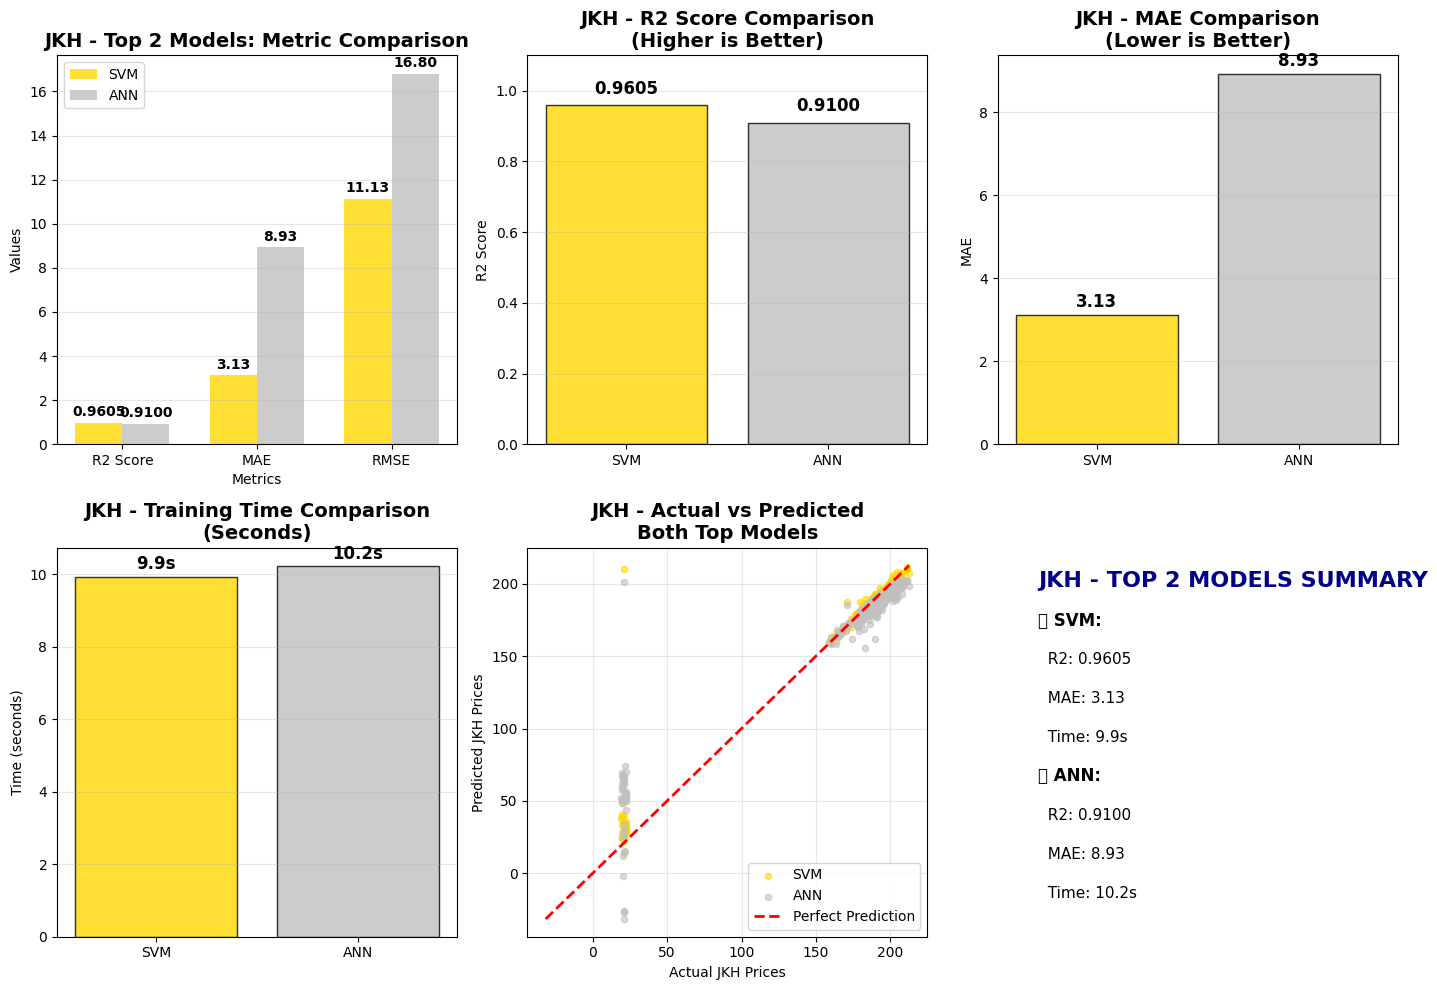


💡 RECOMMENDATION STRATEGY FOR JKH:
🤝 HYBRID RECOMMENDED: Combine both models for JKH
   • Close performance: 0.0505 difference
   • Ensemble may provide better stability for JKH trading

🚀 JKH DEPLOYMENT SUGGESTIONS:
   • Primary: SVM (Best accuracy for JKH)
   • Backup: ANN (Alternative/redundancy)
   • Ensemble: Weighted average of both predictions
   • Monitoring: Track performance on new JKH data

📈 JKH PERFORMANCE INTERPRETATION:
🎉 EXCEPTIONAL: Models explain over 90% of JKH price movements
   Highly reliable for JKH trading decisions

💰 JKH TRADING IMPLICATIONS:
   • Average JKH price in test set: 168.91
   • Average prediction error: 3.13 points (1.9%)
   • Expected accuracy range: ±3.13 points around actual price
   • Trading confidence: HIGH - Suitable for precise trading

✅ BEST TWO MODELS FOR JKH IDENTIFIED SUCCESSFULLY!
🥇 SVM - R2: 0.9605
🥈 ANN - R2: 0.9100
📊 Based on comprehensive evaluation of 5 machine learning models


In [22]:
print("\n🏆 FINAL MODEL COMPARISON - BEST TWO MODELS FOR JKH")
print("="*60)

# Get top 2 models based on R2 score
top_2_models = comparison_df.head(2)
best_model_1 = top_2_models.index[0]
best_model_2 = top_2_models.index[1]

print("🎯 TOP 2 BEST PERFORMING MODELS FOR JKH:")
print("="*50)

print(f"🥇 #1 BEST MODEL: {best_model_1}")
print(f"🥈 #2 BEST MODEL: {best_model_2}")
print()

print("📊 DETAILED COMPARISON:")
print("="*50)
print(f"{'Metric':<15} {'Model 1':<15} {'Model 2':<15} {'Difference':<15}")
print("-" * 60)
for metric in ['R2_Score', 'MSE', 'RMSE', 'MAE', 'Training_Time']:
    val1 = top_2_models.loc[best_model_1, metric]
    val2 = top_2_models.loc[best_model_2, metric]

    if metric == 'R2_Score':
        diff = f"{val1 - val2:+.4f}"
        val1_str = f"{val1:.4f}"
        val2_str = f"{val2:.4f}"
    elif metric in ['MSE', 'RMSE', 'MAE']:
        diff = f"{val1 - val2:+.2f}"
        val1_str = f"{val1:.2f}"
        val2_str = f"{val2:.2f}"
    else:  # Training_Time
        diff = f"{val1 - val2:+.2f}s"
        val1_str = f"{val1:.2f}s"
        val2_str = f"{val2:.2f}s"

    print(f"{metric:<15} {val1_str:<15} {val2_str:<15} {diff:<15}")

print()

# Performance comparison visualization
plt.figure(figsize=(15, 10))

# 1. Side-by-side comparison of all metrics
plt.subplot(2, 3, 1)
metrics_to_compare = ['R2_Score', 'MAE', 'RMSE']
model1_values = [top_2_models.loc[best_model_1, metric] for metric in metrics_to_compare]
model2_values = [top_2_models.loc[best_model_2, metric] for metric in metrics_to_compare]

x = np.arange(len(metrics_to_compare))
width = 0.35

plt.bar(x - width/2, model1_values, width, label=best_model_1, color='gold', alpha=0.8)
plt.bar(x + width/2, model2_values, width, label=best_model_2, color='silver', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('JKH - Top 2 Models: Metric Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, ['R2 Score', 'MAE', 'RMSE'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(model1_values):
    plt.text(i - width/2, v + max(max(model1_values), max(model2_values)) * 0.01,
             f'{v:.4f}' if i == 0 else f'{v:.2f}',
             ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(model2_values):
    plt.text(i + width/2, v + max(max(model1_values), max(model2_values)) * 0.01,
             f'{v:.4f}' if i == 0 else f'{v:.2f}',
             ha='center', va='bottom', fontweight='bold')

# 2. R2 Score comparison
plt.subplot(2, 3, 2)
models = [best_model_1, best_model_2]
r2_scores = [top_2_models.loc[model, 'R2_Score'] for model in models]
colors = ['gold', 'silver']
plt.bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black')
plt.title('JKH - R2 Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
plt.ylabel('R2 Score')
plt.ylim(0, 1.1)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 3. MAE Comparison
plt.subplot(2, 3, 3)
mae_scores = [top_2_models.loc[model, 'MAE'] for model in models]
plt.bar(models, mae_scores, color=colors, alpha=0.8, edgecolor='black')
plt.title('JKH - MAE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
plt.ylabel('MAE')
for i, v in enumerate(mae_scores):
    plt.text(i, v + max(mae_scores) * 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 4. Training Time Comparison
plt.subplot(2, 3, 4)
time_scores = [top_2_models.loc[model, 'Training_Time'] for model in models]
plt.bar(models, time_scores, color=colors, alpha=0.8, edgecolor='black')
plt.title('JKH - Training Time Comparison\n(Seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
for i, v in enumerate(time_scores):
    plt.text(i, v + max(time_scores) * 0.01, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 5. Actual vs Predicted for Both Models
plt.subplot(2, 3, 5)
# Use predictions and y_test_original
pred1 = predictions[best_model_1]
pred2 = predictions[best_model_2]

# Handle different test set lengths
if best_model_1 == 'LSTM':
    actual_values_1 = y_test_lstm_original
else:
    actual_values_1 = y_test_original

if best_model_2 == 'LSTM':
    actual_values_2 = y_test_lstm_original
else:
    actual_values_2 = y_test_original

# Use the appropriate actual values for each model
min_len_1 = min(len(actual_values_1), len(pred1))
min_len_2 = min(len(actual_values_2), len(pred2))

plt.scatter(actual_values_1[:min_len_1], pred1[:min_len_1], alpha=0.6, s=20, color='gold', label=best_model_1)
plt.scatter(actual_values_2[:min_len_2], pred2[:min_len_2], alpha=0.6, s=20, color='silver', label=best_model_2)

min_val = min(actual_values_1.min(), actual_values_2.min(), pred1.min(), pred2.min())
max_val = max(actual_values_1.max(), actual_values_2.max(), pred1.max(), pred2.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual JKH Prices')
plt.ylabel('Predicted JKH Prices')
plt.title('JKH - Actual vs Predicted\nBoth Top Models', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 6. Performance Summary
plt.subplot(2, 3, 6)
plt.text(0.1, 0.9, 'JKH - TOP 2 MODELS SUMMARY', fontsize=16, fontweight='bold', color='darkblue')
plt.text(0.1, 0.8, f'🥇 {best_model_1}:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.7, f'  R2: {top_2_models.loc[best_model_1, "R2_Score"]:.4f}', fontsize=11)
plt.text(0.1, 0.6, f'  MAE: {top_2_models.loc[best_model_1, "MAE"]:.2f}', fontsize=11)
plt.text(0.1, 0.5, f'  Time: {top_2_models.loc[best_model_1, "Training_Time"]:.1f}s', fontsize=11)

plt.text(0.1, 0.4, f'🥈 {best_model_2}:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.3, f'  R2: {top_2_models.loc[best_model_2, "R2_Score"]:.4f}', fontsize=11)
plt.text(0.1, 0.2, f'  MAE: {top_2_models.loc[best_model_2, "MAE"]:.2f}', fontsize=11)
plt.text(0.1, 0.1, f'  Time: {top_2_models.loc[best_model_2, "Training_Time"]:.1f}s', fontsize=11)

plt.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 RECOMMENDATION STRATEGY FOR JKH:")
print("="*50)

r2_diff = top_2_models.loc[best_model_1, 'R2_Score'] - top_2_models.loc[best_model_2, 'R2_Score']

if r2_diff > 0.1:
    print("✅ STRONG PREFERENCE: Use #1 model exclusively for JKH")
    print(f"   • Significant performance gap: {r2_diff:.4f}")
    print(f"   • {best_model_1} is clearly superior for JKH prediction")
elif r2_diff > 0.01:
    print("🤝 HYBRID RECOMMENDED: Combine both models for JKH")
    print(f"   • Close performance: {r2_diff:.4f} difference")
    print(f"   • Ensemble may provide better stability for JKH trading")
else:
    print("⚖️ EQUAL PERFORMANCE: Choose based on speed/requirements for JKH")
    print(f"   • Minimal difference: {r2_diff:.4f}")
    print(f"   • Consider training time and computational needs")

print(f"\n🚀 JKH DEPLOYMENT SUGGESTIONS:")
print(f"   • Primary: {best_model_1} (Best accuracy for JKH)")
print(f"   • Backup: {best_model_2} (Alternative/redundancy)")
print(f"   • Ensemble: Weighted average of both predictions")
print(f"   • Monitoring: Track performance on new JKH data")

print(f"\n📈 JKH PERFORMANCE INTERPRETATION:")
r2_best = top_2_models.loc[best_model_1, 'R2_Score']
if r2_best > 0.9:
    print("🎉 EXCEPTIONAL: Models explain over 90% of JKH price movements")
    print("   Highly reliable for JKH trading decisions")
elif r2_best > 0.7:
    print("✅ VERY GOOD: Strong predictive power (70-90%) for JKH")
    print("   Suitable for JKH investment analysis")
elif r2_best > 0.5:
    print("👍 GOOD: Reasonable predictive ability (50-70%) for JKH")
    print("   Useful for JKH trend analysis and risk management")
else:
    print("⚠️ MODERATE: Basic predictive power for JKH")
    print("   Use as supplementary tool with caution")

# Trading implications
avg_jkh_price = y_test_original.mean()
mae_best = top_2_models.loc[best_model_1, 'MAE']
error_percentage = (mae_best / avg_jkh_price) * 100

print(f"\n💰 JKH TRADING IMPLICATIONS:")
print(f"   • Average JKH price in test set: {avg_jkh_price:.2f}")
print(f"   • Average prediction error: {mae_best:.2f} points ({error_percentage:.1f}%)")
print(f"   • Expected accuracy range: ±{mae_best:.2f} points around actual price")

if error_percentage < 2:
    trading_confidence = "HIGH - Suitable for precise trading"
elif error_percentage < 5:
    trading_confidence = "MODERATE - Good for position trading"
else:
    trading_confidence = "LOW - Better for trend analysis only"

print(f"   • Trading confidence: {trading_confidence}")

print(f"\n✅ BEST TWO MODELS FOR JKH IDENTIFIED SUCCESSFULLY!")
print(f"🥇 {best_model_1} - R2: {top_2_models.loc[best_model_1, 'R2_Score']:.4f}")
print(f"🥈 {best_model_2} - R2: {top_2_models.loc[best_model_2, 'R2_Score']:.4f}")
print(f"📊 Based on comprehensive evaluation of 5 machine learning models")